In [3]:
import os
from TSenCA.ContactAnalysis.ContactFrequencies import *
%load_ext autoreload
%autoreload 2

In [4]:
# getcontacts frequency files are all in here
frequency_dir = 'data/getcontacts_frequency_files'
# list them
frequency_files = [f'{frequency_dir}/{file}' for file in os.listdir(frequency_dir)]
# Now turn all the frequency data into a dictionary where each key is a contact id and
# each value is a list of contact frequencies across all the simulated temperatures
contact_frequency_dictionary = make_contact_frequency_dictionary(frequency_files)
# Now put this into a dataframe that the ContactFrequency class accepts
cont = ContactFrequencies(pd.DataFrame(contact_frequency_dictionary))

In [5]:
# TRPV3 is a homotetramer so you can average the contact frequencies from all 4 subunits
# this will give better statistics on the contacts and simplify analysis
# adding a structure file is a good idea on a multimer so that when you go to visualize it,
# the correct contact pair is depicted.
avg_df = cont.average_contacts(structure='data/TRPV3_structure.pdb')

This can take a few minutes..


/Users/dburns/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:431: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


In [7]:
# make a list of the simulation temperatures and replace the index with the corresponding temperatures
nrep = 28
tmin = 300
tmax = 420
temps = []
for i in range(nrep):
    t=tmin*np.exp(i*np.log(tmax/tmin)/(nrep-1))
    temps.append(int(t))

tempsC = []
for C in temps:
    tempsC.append(round(C - 273.15))

avg_df.set_axis(tempsC, axis='index',inplace=True)

Text(0, 0.5, 'Projection')

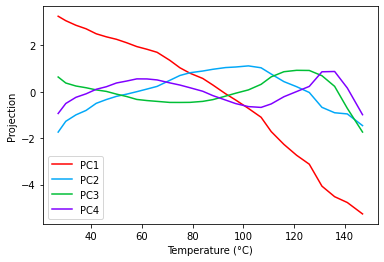

In [22]:
# Let's do PCA on this data and see what the first several PC projections look like
import matplotlib.pyplot as plt
pca = PCA(n_components=.99999)
pca.fit(avg_df)
pcs=pca.transform(avg_df)
fig, ax = plt.subplots()
colors = ['red','#02a8f8','#00bf36','#8000ff']
for i in range(len(colors)):
    ax.plot(tempsC, -1*pcs[:,i], color=colors[i])
ax.legend(['PC'+str(i+1) for i in range(len(colors))])
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Projection')

PC 1 describes a melting trend where contact frequency decreases as temperature increases
PC 2 describes a trend of increasing order with temperature

In [9]:
# The ContactPCA class makes further analysis of the PCs easy
pca_df = ContactPCA(avg_df)

In [12]:
# Now we have a ContactPCA object that makes it easy to analyze the PCs
# If we sort the PCs according to absolute loading score value, we can see which contacts are the most temperature sensitive
# Let's see which residue interactions have the strongest tendency to melt
pca_df.sorted_norm_loadings(1)[['PC1']]

,PC1
A:GLU:263-A:SER:294,1.000000
A:ASP:293-A:TYR:260,0.982109
A:ASP:293-A:GLU:263,0.979657
A:GLN:292-A:HSD:244,0.934201
A:ARG:295-A:ASN:339,0.826522
...,...
A:GLY:502-A:PHE:524,0.000000
A:LYS:246-B:ASP:752,0.000000
A:ARG:188-A:GLN:227,0.000000
A:LYS:368-A:MET:336,0.000000


In [24]:
# We can also look at which contacts display the interesting behavior of increasing contact frequency with increasing temperature
pca_df.sorted_norm_loadings(2)[['PC2']]

,PC2
A:LEU:508-A:THR:411,1.000000
A:TYR:213-B:PRO:753,0.903384
A:GLY:638-A:GLY:640,0.874634
A:LEU:639-B:LEU:639,0.845681
A:LEU:635-B:ILE:637,0.788465
...,...
A:ILE:583-A:TYR:575,0.000000
A:ASP:288-A:GLU:334,0.000000
A:GLU:367-B:PRO:181,0.000000
A:GLU:332-A:THR:399,0.000000


In [25]:
# Looking at the normalized loading scores doesn't discriminate between which residues are positively or negatively correlated on the PC
# you can look at these by using pca_df.sorted_loadings() 
pca_df.sorted_loadings(2)[['PC2']]
# Here, they're still sorted by absolute value

,PC2
A:LEU:508-A:THR:411,-0.102860
A:TYR:213-B:PRO:753,0.092922
A:GLY:638-A:GLY:640,0.089965
A:LEU:639-B:LEU:639,-0.086987
A:LEU:635-B:ILE:637,-0.081102
...,...
A:ILE:583-A:TYR:575,-0.000000
A:ASP:288-A:GLU:334,-0.000000
A:GLU:367-B:PRO:181,-0.000000
A:GLU:332-A:THR:399,-0.000000


<AxesSubplot:>

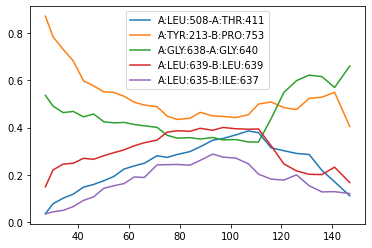

In [26]:
# We can go back to our original contact frequency data and plot these top contacts to see what their sign means
# Let's get the top 5 contacts on PC 2
contacts = pca_df.sorted_loadings(2)[['PC2']].index[:5]
avg_df[contacts].plot()

In [ ]:
# you can see that being positively correlated on PC 2 means a decreasing contact frequency through the lower temperature range
# Of course it's way more interesting to visualize this data on the protein itself.